<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/mars_challenge/kalman_filter_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kalman Filter Tutorial**

In this notebook we will apply a 1D Kalman Filter to smooth the camera speed data in the Mars Challenge.

To implement the Kalman Filter we will use [filterpy](https://filterpy.readthedocs.io/en/latest/). For some background on the Kalman Filter I strongly recomment [KalmanFIlter.net](https://www.kalmanfilter.net/default.aspx)


## **References**
- https://www.kalmanfilter.net/multiSummary.html
- https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html
- https://filterpy.readthedocs.io/en/latest/common/common.html
- https://www.mathworks.com/help/fusion/ref/constacc.html

Get Data

In [ ]:
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.mp4
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.txt

Install Libraries

In [ ]:
!pip install filterpy

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
y_train = np.loadtxt("train.txt")

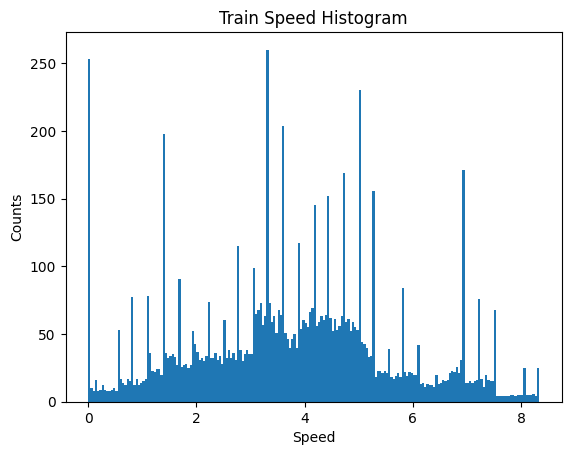

In [5]:
plt.hist(y_train, bins=200);
plt.title("Train Speed Histogram")
plt.xlabel("Speed")
plt.ylabel("Counts");

We can see in the histogram, that there are a lot of "spikey modes", this happens when the speed erroneously stays at a single value for a brief period of time. It seems like the measurment device was faulty or more likely the makers of the challenge decided to give us some noisy data. Either way we need to do something about this if we want to sucessfully predict the speed. In this case, we will use a Linear Kalman Filter with a constant acceleration model, we will assume that we are working with single vector of position, velocity, and acceleration. Eventhough speed is a scalar quantity.

<br>

For the measured parameters, we will use the provided speed along with the acceleration if available. We can get the accleration with:
<br>

$$ \frac{speed_{t_1} - speed_{t_1}}{t_1 - t_0}$$

We will need to use a 0 acceleration to augment the acceleration for the first video frame.

**IMPORTANT NOTE!** Since we are changing the original data we will need to be careful to apply the exact same Kalman Filtering before we train and before perform inference with a trained model. We can think of the Kalman Filter parameters as hyperparameters in our Machine Learning pipeline, since the data we use to train a model has an impact on model performance and this Kalman Filter will have an impact on our model.

In [103]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# parameters
dt = 1 # time step
q_var = 0.13 # Process noise covariance
r_var = 20.0 # measurment noise covairance
x_var = 1000.0 # process noise covariance


#  wrap in function to make parameter tuning easier
def get_kalman_filter(dt, q_var, r_var, x_var):
    """
    dt - time step
    q_var - Process noise covariance
    r_var - measurment noise covairance
    x_var - process noise covariance
    """

    # creat Kalman Filter Object
    kf = KalmanFilter (dim_x=3, dim_z=2)

    # state vector
    kf.x = np.array([[0.0],  # position
                    [0.0],  # velocity
                    [0.0]]) # acceleration

    # state transition matrix
    kf.F = np.array([[1, dt, 0.5*dt**2],  # x position
                     [0,  1,        dt],  # x velocity
                     [0,  0,         1]]) # x speed

    # measurement matrix (funtion) --> only measure velocity and acceleration
    kf.H = np.array([[0.0, 1.0, 1.0],
                    [0.0, 0.0, 1.0]])

    # covariance matrix
    kf.P *= x_var

    # measurment noise
    kf.R *= r_var

    # Process Noise
    kf.Q = Q_discrete_white_noise(dim=3, dt=dt, var=q_var)

    return kf

# create kalman Filter Object
kf = get_kalman_filter(dt, q_var, r_var, x_var)

Apply Kalman Filter to data

In [108]:
def get_filtered_states(y_data):
    x_states = []

    prev_xs = 0.0
    z = np.array([[0.0, 0.0]])
    for xs in y_data:

        # get measurements
        xa = (xs - prev_xs)/dt
        z = np.array([[xs, 0.0]])

        # update with new measurement
        kf.update(z)
        x_states.append(kf.x)

        # predict next state
        kf.predict()

    return np.array(x_states)


x_states = get_filtered_states(y_train)
y_train_smooth = x_states[:, 1]

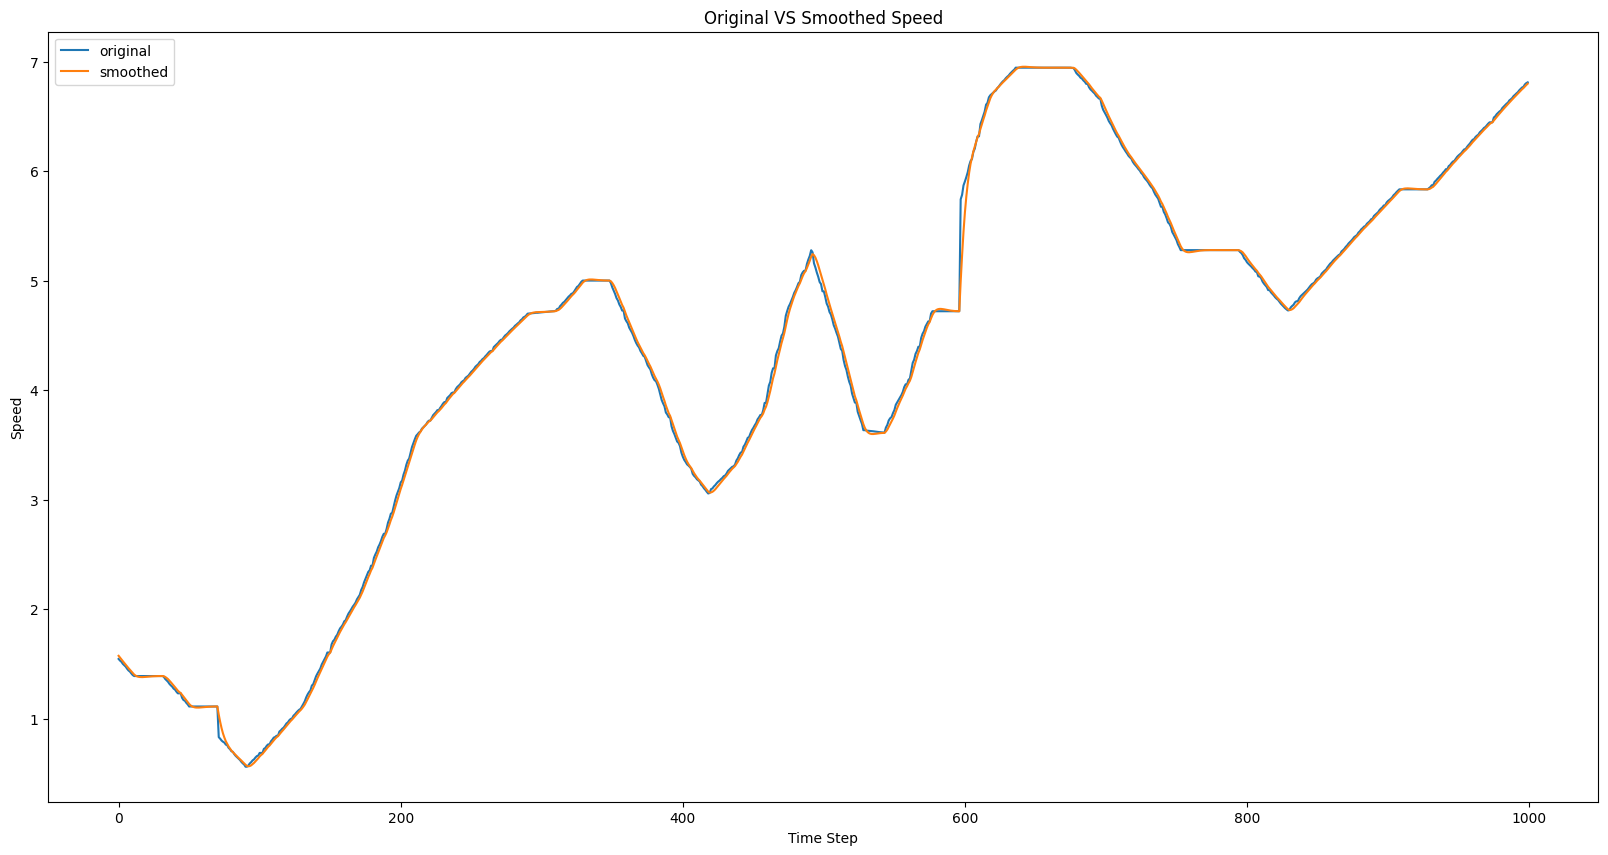

In [109]:
plt.figure(figsize=(20, 10))
plt.plot(y_train[4000:5000], label='original')
plt.plot(y_train_smooth[4000:5000], label='smoothed')
plt.title("Original VS Smoothed Speed")
plt.xlabel("Time Step")
plt.ylabel("Speed")
plt.legend();

## **Draw Filtered Speeds on Video**

In [110]:
# font
font = cv2.FONT_HERSHEY_SIMPLEX

# org
org_true = (15, 30)
org_pred = (15, 65)

# fontScale
fontScale = 1

# Blue color in BGR
color_true = (5, 255, 5)
color_pred = (255, 255, 255)

# Line thickness of 2 px
thickness = 3

In [112]:
cap = cv2.VideoCapture("train.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

train_fps = cap.get(cv2.CAP_PROP_FPS)
frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        # get train truth and prediction
        if i == 0:
          y_true = y_train[i]
          y_pred = y_train_smooth[i][0]
        else:
          y_true = y_train[i-1]
          y_pred =y_train_smooth[i-1][0]

        # draw speeds on frame
        frame = cv2.putText(frame, f"OG Speed: {y_true:.3f}", org_true, font,
                    fontScale, (0,0,0), 15, cv2.LINE_AA)
        frame = cv2.putText(frame, f"OG Speed: {y_true:.3f}", org_true, font,
                            fontScale, color_true, thickness, cv2.LINE_AA)

        frame = cv2.putText(frame, f"Filtered Speed: {y_pred:.3f}", org_pred, font,
                            fontScale, (0,0,0), 15, cv2.LINE_AA)
        frame = cv2.putText(frame, f"Filtered Speed: {y_pred:.3f}", org_pred, font,
                            fontScale, color_pred, thickness, cv2.LINE_AA)

        # save to list
        frames.append(frame)

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

In [113]:
# save to mp4
w, h = frames[-1].shape[:2][::-1]
out = cv2.VideoWriter("train_filtered_speed.mp4",
                      cv2.VideoWriter_fourcc(*'MP4V'),
                      train_fps,
                      (w, h))

for frame in frames:
    out.write(frame)
out.release()
del out